## **MAGPIE: an interactive tool for visualizing and analyzing many simultaneous protein interactions with a binding partner**

**What is this tool?**
This online tool, hosted on Google Colab, is designed to generate sequence logos based on the distance from a target residue or ligand in a given dataset of pdbs. The distance is calculated using the alpha carbon positions between protein interfaces or all non-hydrogen atoms in the case of ligands. The tool also includes a 3D visualizer that plots the entire target structure and highlights the residues within the specified distance constraint. There are two options for colering the interacting residues based on [Amino colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#aminocolours) and [Shapely colour](http://acces.ens-lyon.fr/biotic/rastop/help/colour.htm#shapelycolours).

**Required Inputs:**
- PDB Files: Two examples are provided on GitHub, one for protein-protein interactions and one for ligand-protein interactions.
- Target Chain from PDB: The program uses the first file in the directory to upload the target structure.
- Interacting Chain from PDB: This chain identifier must be the same across all PDB files.
- Specify Target Type: Indicate whether the target is a ligand or a protein.
- Target Residue Index (for proteins) or Unique Atom Names (for ligands): Provide the target residue index for proteins or unique atom names for ligands. Alternatively, you can input 'All' to consider all residues/atoms.

**Usage:**
Please execute the cells in numerical order. If you wish to load a different dataset, you can start from the upload step to reload the new data.


In [1]:
#@title ##1. Install and import required packages
%%capture

from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/glasgowlab/MAGPIE.git
%cd MAGPIE
!pip install logomaker
!pip install rarfile
import pandas as pd
import helper_functions
import sequence_logo_main
import os
import glob
import zipfile
import tarfile
import rarfile
%matplotlib notebook
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
try:
  os.mkdir('temp')
except:
  print("Done")



In [ ]:
#@title ##2. Upload data, and process
#@markdown Navigate to the File menu located top left of the screen. Upload data into the **Temp** directory, in the form of a compressed directory in zip format containing pdb. It is also possible to directly upload pdb files into temp folder but this might take a long time depending on the number of files.
#@markdown There are two example datasats to test the tool with, a ligand-protein exampple and a protein-protein example.
#@markdown Select which data set you would like to use:
import zipfile


def extract_file(archive_path, output_folder):
    if zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)
    else:
        print(f"{archive_path} is not a zip file")

uploaded_data_set = False #@param {type:"boolean"}
protein_protein_example_data = False  #@param {type:"boolean"}
protein_ligand_example_data = True  #@param {type:"boolean"}
if uploaded_data_set:
  zip_files = glob.glob("temp/" +"*.zip")
  files = zip_files
  pdb_files =[]
  for zip in files:
      extract_file(zip, "temp")
      zip = zip.split(".zip")[0]
      pdb_files +=  glob.glob(zip + "/*.pdb")

elif protein_ligand_example_data:
  pdb_files = glob.glob("Ligand Example/" + "*.pdb")
elif protein_protein_example_data:
    pdb_files = glob.glob("Protein Example/" + "*.pdb")

print(pdb_files)

['Ligand Example/6zzk.pdb', 'Ligand Example/7b4r.pdb', 'Ligand Example/6nds.pdb', 'Ligand Example/7s3u.pdb', 'Ligand Example/7uul.pdb', 'Ligand Example/7n8e.pdb', 'Ligand Example/6he2.pdb', 'Ligand Example/6qwu.pdb', 'Ligand Example/6as5.pdb', 'Ligand Example/6p7k.pdb', 'Ligand Example/7xwv.pdb', 'Ligand Example/7bcz.pdb', 'Ligand Example/5xuk.pdb', 'Ligand Example/6b3t.pdb', 'Ligand Example/6arb.pdb', 'Ligand Example/6be0.pdb', 'Ligand Example/8a9n.pdb', 'Ligand Example/6j1e.pdb', 'Ligand Example/6ct5.pdb', 'Ligand Example/7ed0.pdb']


In [ ]:
#@title ##3. Select target and binding chains.

#@markdown Select target chain, binding chain, decide whether the target is a ligand or protein, atom names (if ligand) or residue index(if protein) to plot around, and distance to graph from target chain.

#@markdown You can also type 'all' to plot all residues or atoms.

#@markdown For protein example use A for target chain and B for binding chain.

#@markdown For ligand example use Z for target chain and B for binding chain. Use is_ligand function.

target_chain = "X"#@param {type:"string"}
binding_chain = "A"#@param {type:"string"}
to_plot = "N1A,C6A"#@param {type:"string"}
is_ligand = True #@param {type:"boolean"}
distance = '4' #@param {type:"string"}
distance = int(distance)

if to_plot == "all":
  plot_list = "all"

else:
    if is_ligand:
      plot_list = [str(x) for x in to_plot.split(",")]
    else:
      plot_list =[int(x) for x in to_plot.split(",")]



In [ ]:
#@title #4. Plot points in 3d viewer
#@markdown This might take a couple of minutes depending of the size of the data set. Takes ~1 around one minute for protein-protein example.
from matplotlib.pyplot import plot
configure_plotly_browser_state()
df_target,df_binder = sequence_logo_main.plot(pdb_files, target_chain,binding_chain,is_ligand,plot_list, distance)



In [ ]:


#@title #5. Select residues or atoms to generate sequence logos.
#@markdown Enter the residue number or carbon names to graph and separated by a commas.
#@markdown
#@markdown If there are no residues within the given range, next cell will not execute.
sequence_logo_targets = "CDP"#@param {type:"string"}

if is_ligand:
  plot_list = [str(x) for x in sequence_logo_targets.split(",")]
else:
  plot_list =[int(x) for x in sequence_logo_targets.split(",")]



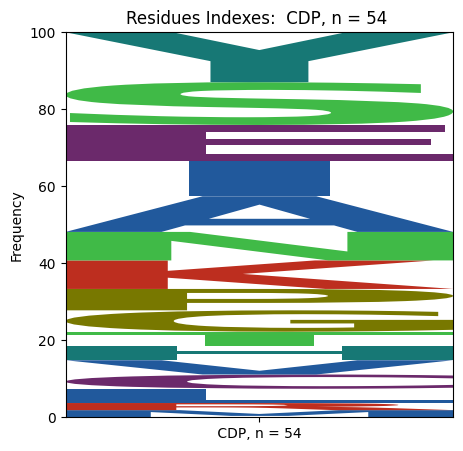

In [ ]:
#@title #6.  Generate sequence logos
#@markdown Select if you'd like to only see the combained logo.

combined = True #@param {type:"boolean" }
%matplotlib inline
sequence_logo_main.sequence_logos(df_target,df_binder, plot_list, is_ligand,combined, distance)